In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
import numpy as np
import jax
import jax.numpy as jnp
import torch.nn.functional as F
from einops import rearrange
import random

In [17]:
SEED = 1717
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [18]:
import matplotlib.pyplot as plt

In [19]:
import neural_tangents as nt
import neural_tangents.stax as stax

In [20]:
from tqdm import tqdm
import time
import argparse
import csv
import os
import pickle

In [21]:
import sys
sys.path.append("./crfm_src")

import models
import utils
import grads
import dataset

## Star dataset

In [42]:
n_train = 200
n_test = 200

train_X, test_X, train_y, test_y = dataset.get_star(n_train, n_test)

num_classes = 2
reg = 1e-3
ps = 3
depth = 3
num_iters = 4

In [43]:
train_X_exp = utils.expand_image(train_X, ps)
test_X_exp = utils.expand_image(test_X, ps)

train_X_exp = torch.moveaxis(train_X_exp,1,-1).numpy()
test_X_exp = torch.moveaxis(test_X_exp,1,-1).numpy()
y_train = train_y.numpy()
y_test = test_y.numpy()
train_X_exp, test_X_exp = jnp.array(train_X_exp), jnp.array(test_X_exp)

_, _, kernel_fn = models.Vanilla(ps=ps, depth=depth, expanded=True)

In [44]:
accs = []
mses = []
M = None
for t in range(num_iters):

    if M is not None:
        del train_X_M
        del test_X_M

        train_X_M = utils.multiply_patches(train_X_exp, M, ps)
        test_X_M = utils.multiply_patches(test_X_exp, M, ps)
    else:
        train_X_M = train_X_exp
        test_X_M = test_X_exp


    start = time.time()
    Ktrain = utils.batch_kernel(kernel_fn, train_X_M, train_X_M)
    end = time.time()
    print(f'Ktrain time {end-start}')

    start = time.time()
    Ktest = utils.batch_kernel(kernel_fn, test_X_M, train_X_M)
    end = time.time()
    print(f'Ktest time {end-start}')

    scale = Ktrain.max()
    Ktrain /= scale
    Ktest /= scale

    start = time.time()
    alphas=np.linalg.solve(reg*np.eye(n_train, dtype=np.float32)+Ktrain, y_train.astype(np.float32))
    end = time.time()
    print(f'Solve time {end-start}')

    ypred = Ktest@alphas
    acc = np.mean(1.0*(np.argmax(ypred,axis=1) == np.argmax(y_test,axis=1))) * 100
    mse = np.mean(np.sum((ypred - y_test)**2,axis=1))

    accs.append(acc)
    mses.append(mse)
    print(f'Round {t} accuracy:', acc)
    print(f'Round {t} MSE:', mse)
    print()
    
    if t < num_iters - 1:
        s = 20
        Xs = train_X_exp[:s]
        M = grads.get_grads(kernel_fn, jnp.array(alphas), train_X_M, Xs, M, num_classes, ps)

        M = utils.matrix_sqrt(M)
        M = jnp.array(M.numpy())
        M = M/np.linalg.norm(M)

Ktrain time 0.40135812759399414
Ktest time 0.0581355094909668
Solve time 0.0004961490631103516
Round 0 accuracy: 89.0
Round 0 MSE: 0.34232345



100%|██████████| 2/2 [00:00<00:00,  4.28it/s]


Ktrain time 0.0225677490234375
Ktest time 0.05780339241027832
Solve time 0.0005125999450683594
Round 1 accuracy: 95.5
Round 1 MSE: 0.12996396



100%|██████████| 2/2 [00:00<00:00,  4.19it/s]


Ktrain time 0.02211737632751465
Ktest time 0.057616472244262695
Solve time 0.0004763603210449219
Round 2 accuracy: 95.0
Round 2 MSE: 0.14005527



100%|██████████| 2/2 [00:00<00:00,  4.20it/s]

Ktrain time 0.022214412689208984
Ktest time 0.05823850631713867
Solve time 0.00047588348388671875
Round 3 accuracy: 94.66666666666667
Round 3 MSE: 0.14319079



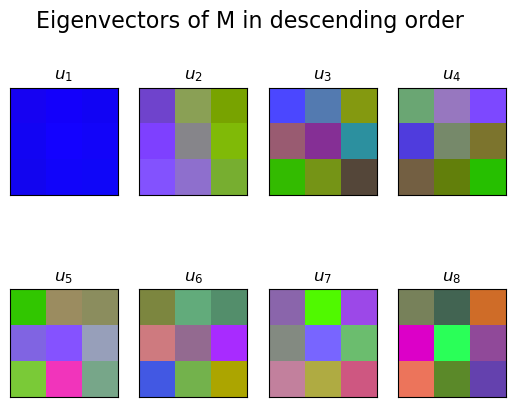

In [45]:
# plot top k eigvs of M
def scale(x):
    return (x - x.min())/(x.max() - x.min())

fig, axes = plt.subplots(2,4)
fig.suptitle("Eigenvectors of M in descending order", fontsize=16)

topk = 8 
S, U = jnp.linalg.eigh(M)
i = 0
j = 0
for k in range(topk):
    uk = U[:,-1-k]
    uk = np.transpose(uk.reshape(3,3,3),(1,2,0))
    
    if k==4:
        j += 1
        i = 0
    
    ax = axes[j][i]
    ax.imshow(scale(uk))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.title.set_text(rf'$u_{k+1}$')
    
    i += 1

## Visualizing filters

In [46]:
def expand_image(X, ps=3):
    """
    X : (n, c, p, q)
    out : (n, c, p*ps, q*ps)
    """

    n, c, p, q = X.shape

    pad_sz = ps//2
    X_patched = torch.from_numpy(np.pad(X, ((0,0),(0,0),(pad_sz,pad_sz),(pad_sz,pad_sz)), mode='wrap'))

    X_patched = X_patched.unfold(2,ps,1).unfold(3,ps,1) # (n, c, p, q, ps, ps)
    X_patched = X_patched.transpose(-2,-3) # (n, c, p, ps, q, ps)
    X_expanded = X_patched.reshape(n,c,p*ps,q*ps)
    return X_expanded

def reduce_image(X, ps=3):
    """
    X : (n, c, p*ps, q*ps)
    out : (n, c, p, q)
    """
    n, c, P, Q = X.shape
    p = P//ps
    q = Q//ps

    X = X.reshape(n, c, p, ps, q, ps)
    X = X.norm(dim=(3,5))
    return X

def multiply_patches(X, M, ps=3):
    """
    X : (n, c, p*ps, q*ps)
    M : (c*w*h, c*w*h)
    out : (n, c, p*ps, q*ps)
    """
    n = X.shape[0]
    chunk = 5000
    leftover_bool = int(n%chunk>0)
    batches = np.array_split(np.arange(n), n//chunk + leftover_bool)

    Xs = []
    for i, b in enumerate(batches):
        Xb = X[b]
        m, c, P, Q = Xb.shape
        p = P//ps
        q = Q//ps
        Xb = rearrange(Xb, 'm c (p w) (q h) -> (m p q) (c w h)', p=p, q=q, w=ps, h=ps)
        Xb = Xb @ M
        Xb = rearrange(Xb, '(m p q) (c w h) -> m c (p w) (q h)', m=m, p=p, q=q, c=c, w=ps, h=ps)
        Xs.append(Xb)
    return torch.cat(Xs, dim=0)

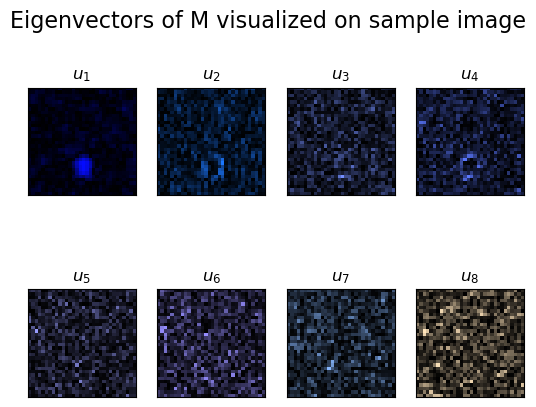

In [47]:
fig, axes = plt.subplots(2,4)
fig.suptitle("Eigenvectors of M visualized on sample image", fontsize=16)

sample_X = train_X[0].unsqueeze(0)
topk = 8 
S, U = jnp.linalg.eigh(M)
i = 0
j = 0
for k in range(topk):
    if k==4:
        j += 1
        i = 0
        
    u = U[:,-1-k]
    u = torch.from_numpy(np.array(np.expand_dims(u,axis=1)))
    uuT = u@u.T
    
    
    Xf = expand_image(sample_X)
    Xf = multiply_patches(Xf, uuT)
    Xf = reduce_image(Xf)
    
    ax = axes[j][i]
    ax.imshow(torch.moveaxis(scale(Xf.squeeze(0)), 0, -1))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.title.set_text(rf'$u_{k+1}$')
    
    i += 1